# Desc

- using this file to practice/learn basic stats
- also want to learn standard time series analysis techniques

In [31]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import r2_score

In [5]:

def check_stationary(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.01) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [6]:
# parameters
_round_num = 2
_time_per_day = 1000000

In [7]:
def get_file_trades(day):
    fname = f"../data/round5/trades_round_{_round_num}_day_{day}_wn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

def get_symbol_prices(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        price_df = get_file_prices(day)
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    
    # rename "bid" to "buy"
    # rename "ask" to "sell"
    price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
    price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df

def get_symbol_trades(symbol, days):
    data = []
    for day in days:
        price_df = get_file_trades(day)
        price_df["day"] = day
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df
    


def get_all_mids(days):
    price_df = get_symbol_prices(symbol=None, days=days)
    
    symbols = set(price_df["symbol"])
    
    price_df["mid"] = (price_df["buy_price_1"] + price_df["sell_price_1"]) / 2
    
    return price_df[["time", "symbol", "mid"]].copy()

In [23]:
def get_book_large_size(price_df, side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    df["symbol"] = price_df["symbol"]
    
    return df


def get_whale_quotes(price_df):
    # get big buy/sell quotes
    buy_df = get_book_large_size(price_df, "buy")
    sell_df = get_book_large_size(price_df, "sell")

    # create big quote_df
    quote_df = pd.merge(buy_df, sell_df, on=["time", "symbol"])
    quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
    quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

    return quote_df

# Counterparty analysis

In [35]:
# load data
# _day_range = [-2, -1, 0]
_day_range = [-1, -0, 1]
# _day_range = [1, 2, 3]
trade_df = get_symbol_trades(None, days=_day_range)
price_df = get_symbol_prices(None, days=_day_range)
price_df = get_whale_quotes(price_df)
_symbols = set(trade_df["symbol"])


# compute all_mid_Df
all_dfs = []

for sym in _symbols:
    df = price_df[price_df["symbol"] == sym]
    
    datas = {
        "time": df["time"],
        "mid": df["mid_price"],
        "symbol": df["symbol"]
    }

    for i in [1, 3, 10, 30, 100, 300, 1000, 3000, 5000]:
        datas[f"d_{i}"] = -1 * df["mid_price"].diff(-1 * i)

    all_dfs += [pd.DataFrame(datas)]

all_mid_df = pd.concat(all_dfs)

# merge into trade_df
trade_df = trade_df.merge(all_mid_df, on=["symbol", "time"])
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid"]

fname ../data/round5/trades_round_2_day_-1_wn.csv
fname ../data/round5/trades_round_2_day_0_wn.csv
fname ../data/round5/trades_round_2_day_1_wn.csv
fname ../data/round2/prices_round_2_day_-1.csv
fname ../data/round2/prices_round_2_day_0.csv
fname ../data/round2/prices_round_2_day_1.csv


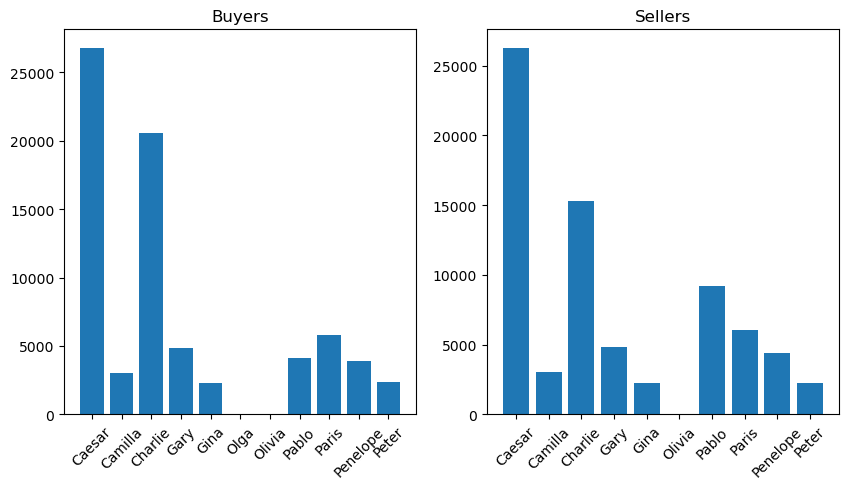

In [38]:
# general plot of data
total_buys = trade_df.groupby(["buyer"])[["quantity"]].sum()
total_sells = trade_df.groupby(["seller"])[["quantity"]].sum()

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.bar(total_buys.index, total_buys["quantity"])
plt.xticks(rotation=45)
plt.title("Buyers")

plt.subplot(122)
plt.bar(total_sells.index, total_sells["quantity"])
plt.xticks(rotation=45)
plt.title("Sellers")
plt.show()

In [28]:
df1 = trade_df.groupby(["symbol", "buyer"])["quantity"].agg(["sum", "count"])
df2 = trade_df.groupby(["symbol", "seller"])["quantity"].agg(["sum", "count"])

df1 = df1.reset_index().rename({"buyer": "party", "sum": "buy_vol", "count": "buy_count"}, axis=1)
df2 = df2.reset_index().rename({"seller": "party", "sum": "sell_vol", "count": "sell_count"}, axis=1)

vol_df = df1.merge(df2, on=["symbol", "party"], how="outer")

for sym in _symbols:
    df = vol_df[vol_df["symbol"] == sym].sort_values(by="buy_vol", ascending=False)
#     df = df[(df["buy_count"] < 20)]
#     display(df.drop(["buy_count", "sell_count"], axis=1))
    display(df)

,symbol,party,buy_vol,buy_count,sell_vol,sell_count
10,COCONUTS,Caesar,18746,480,18848.0,490.0
11,COCONUTS,Charlie,4389,323,1364.0,179.0
13,COCONUTS,Peter,1723,226,1557.0,205.0
12,COCONUTS,Pablo,873,49,3962.0,204.0


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
2,BANANAS,Charlie,10090,3021,9180.0,2630.0
3,BANANAS,Gary,3273,282,3444.0,310.0
8,BANANAS,Paris,3202,2756,3513.0,3108.0
9,BANANAS,Penelope,2543,468,2599.0,498.0
4,BANANAS,Gina,1688,263,1669.0,293.0
1,BANANAS,Camilla,1423,719,1499.0,769.0
7,BANANAS,Pablo,1081,436,1369.0,532.0
0,BANANAS,Caesar,824,650,860.0,455.0
6,BANANAS,Olivia,51,3,51.0,4.0
5,BANANAS,Olga,9,1,NaN,NaN


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
22,PINA_COLADAS,Caesar,5902,381,5305.0,314.0
23,PINA_COLADAS,Charlie,1554,243,431.0,121.0
25,PINA_COLADAS,Peter,622,178,706.0,211.0
24,PINA_COLADAS,Pablo,494,52,2130.0,208.0


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
16,PEARLS,Charlie,4517,1764,4323.0,1731.0
20,PEARLS,Paris,2587,2241,2531.0,2200.0
19,PEARLS,Pablo,1665,658,1761.0,693.0
15,PEARLS,Camilla,1607,754,1516.0,700.0
17,PEARLS,Gary,1548,317,1423.0,299.0
21,PEARLS,Penelope,1383,478,1840.0,621.0
14,PEARLS,Caesar,1314,935,1271.0,902.0
18,PEARLS,Gina,604,137,560.0,138.0


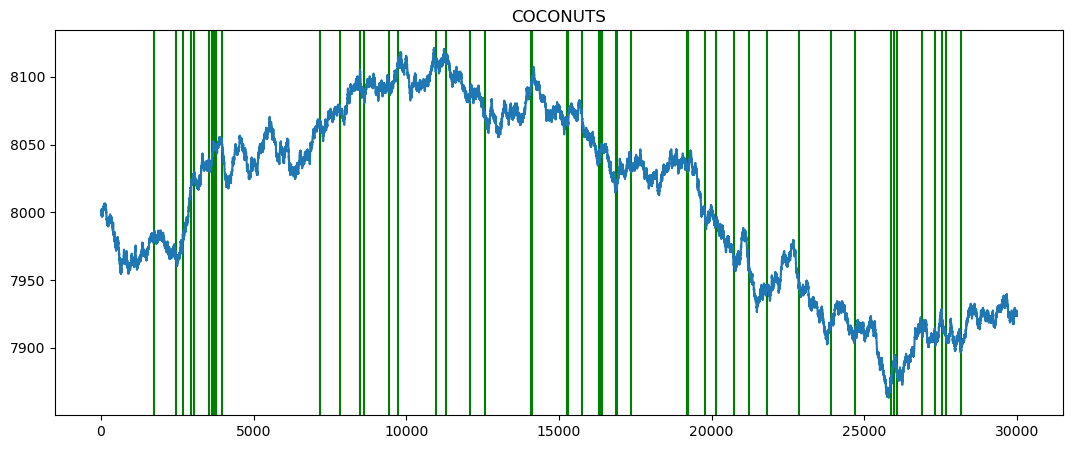

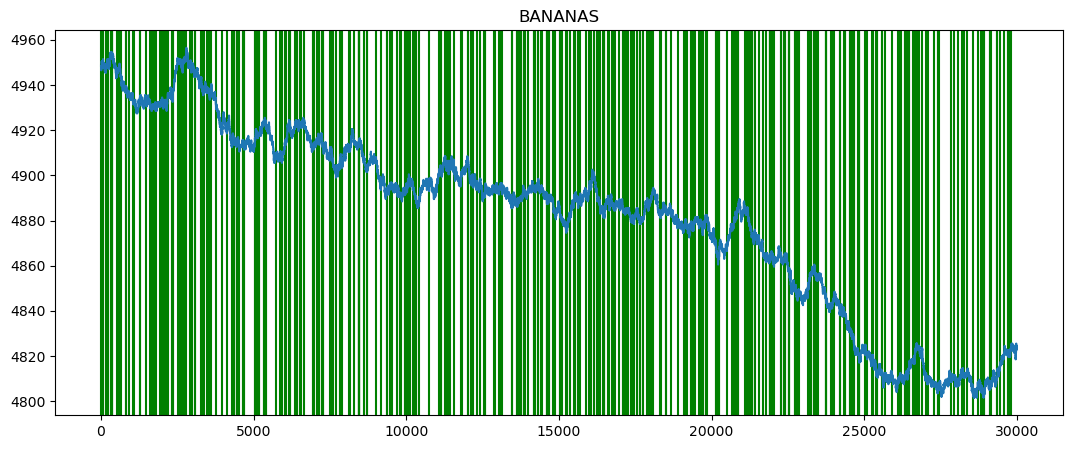

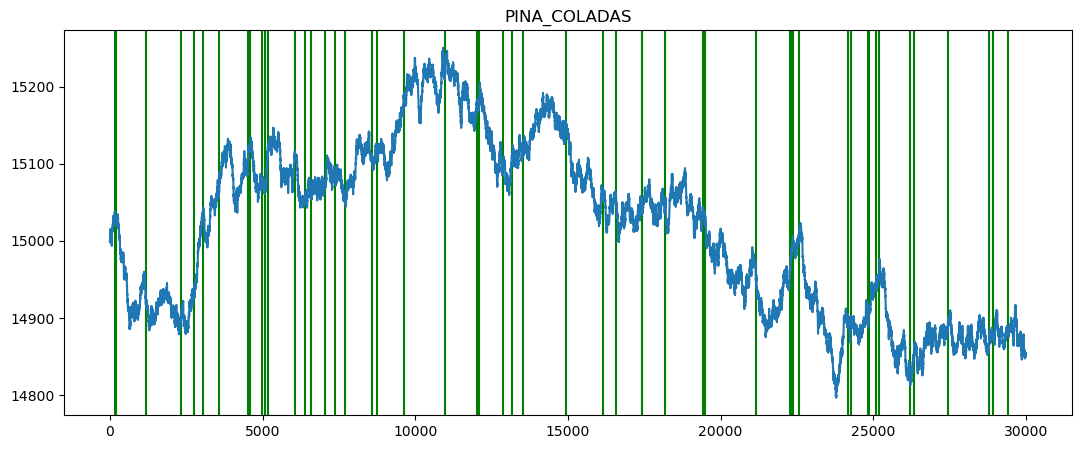

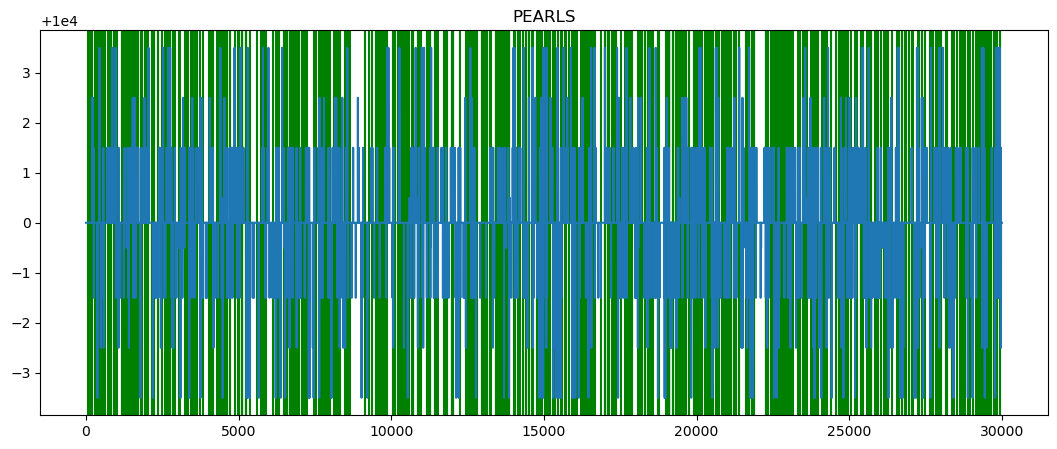

In [41]:
party = "Pablo"

party_trades = trade_df[(trade_df["buyer"] == party) | (trade_df["seller"] == party)]

syms = set(party_trades["symbol"])

for sym in syms:
    plt.figure(figsize=(13, 5))
    df = price_df[price_df["symbol"] == sym].reset_index()
    
    tdf = party_trades[party_trades["symbol"] == sym]
    

    for index, row in tdf.iterrows():
        is_buy = row["buyer"] == party
        if not is_buy:
            continue
        color = "green" if is_buy else "red"
        time = row["time"] // 100
        plt.axvline(x=time, color=color)
    
    plt.plot(df["mid_price"])

    plt.title(sym)
    plt.show()

In [44]:
price_df

,buy_price,buy_size,time,symbol,sell_price,sell_size,mid_price,spread
0,9995.0,29.0,0,PEARLS,10005.0,29.0,10000.0,10.0
1,14998.0,53.0,0,PINA_COLADAS,15002.0,53.0,15000.0,4.0
2,7999.0,162.0,0,COCONUTS,8002.0,107.0,8000.5,3.0
3,4945.0,29.0,0,BANANAS,4952.0,31.0,4948.5,7.0
4,9995.0,22.0,100,PEARLS,10005.0,22.0,10000.0,10.0
...,...,...,...,...,...,...,...,...
119995,7923.0,181.0,2999800,COCONUTS,7926.0,181.0,7924.5,3.0
119996,4820.0,20.0,2999900,BANANAS,4827.0,20.0,4823.5,7.0
119997,9995.0,20.0,2999900,PEARLS,10005.0,20.0,10000.0,10.0
119998,14849.0,62.0,2999900,PINA_COLADAS,14853.0,83.0,14851.0,4.0


# General Analysis Strategy
- find who is making the most money
- find their most profitable types of trades
    - filter by symbols + buy/sell side
    - map their return after 1, 3, 10, 30, ... turns

In [30]:
cols = ["count", "sell_edge"] + [col for col in trade_df.columns if col.startswith("d_")]
sort_by = "d_100"

# in buyers, most positive is best
counts = trade_df.groupby(["buyer", "symbol"])["time"].count()
buys = trade_df.groupby(["buyer", "symbol"]).mean()
buys["count"] = counts
display(buys[cols].sort_values(by=sort_by, ascending=False))
# display(buys[cols])

# in sellers, most negative is best
counts = trade_df.groupby(["seller", "symbol"])["time"].count()
sells = trade_df.groupby(["seller", "symbol"]).mean()
sells["count"] = counts
display(sells[cols].sort_values(by=sort_by, ascending=True))


/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_97872/4203186648.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buys = trade_df.groupby(["buyer", "symbol"]).mean()


,,count,sell_edge,d_1,d_3,d_10,d_30,d_100,d_300,d_1000,d_3000,d_5000
buyer,symbol,,,,,,,,,,,
Olga,BANANAS,1,-2.500000,0.000000,2.000000,4.000000,5.000000,13.000000,15.000000,3.500000,-8.000000,-19.000000
Olivia,BANANAS,3,3.500000,0.500000,0.833333,1.333333,2.666667,2.833333,4.166667,12.000000,-11.500000,-27.000000
Pablo,PINA_COLADAS,52,0.182692,-0.346154,-0.778846,0.048077,1.519231,2.009615,-4.134615,-9.421569,-1.822917,-10.625000
Peter,PINA_COLADAS,178,1.314607,0.213483,-0.014045,0.500000,0.275281,1.969101,-0.343750,-1.258621,-1.907738,-22.697368
Caesar,PINA_COLADAS,381,-0.952756,-0.081365,-0.131234,0.159211,-0.285526,0.888594,-2.131016,-2.228650,-9.572072,-32.822006
Pablo,COCONUTS,49,0.275510,-0.153061,0.061224,-0.132653,-0.030612,0.877551,0.693878,-2.734694,-10.611111,-28.524390
Caesar,COCONUTS,480,-0.514583,0.428125,0.483333,0.477083,0.279167,0.421384,1.042373,0.986985,-1.544289,-11.652393
Peter,COCONUTS,226,1.267699,0.006637,-0.037611,-0.086283,0.086283,0.413333,-0.426339,0.623288,-6.753731,-16.075676
Charlie,PINA_COLADAS,243,-1.557613,-0.162551,-0.063786,-0.267490,0.114108,0.246888,-0.421162,-3.388889,-2.869668,-23.862944


/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_97872/4203186648.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sells = trade_df.groupby(["seller", "symbol"]).mean()


,,count,sell_edge,d_1,d_3,d_10,d_30,d_100,d_300,d_1000,d_3000,d_5000
seller,symbol,,,,,,,,,,,
Olivia,BANANAS,4,-3.250000,-0.250000,-0.375000,-1.000000,-3.000000,-8.500000,-11.250000,-24.500000,-41.500000,-58.000000
Peter,PINA_COLADAS,211,-1.336493,-0.078199,-0.172986,-0.317536,0.428571,-0.765550,-1.397129,-5.159204,-3.128342,-17.497076
Caesar,BANANAS,455,1.309890,-0.094505,-0.079121,-0.081498,-0.128035,-0.591611,-1.223947,-4.195402,-14.231343,-25.363388
Penelope,BANANAS,498,-2.530120,0.007028,0.015060,0.011044,-0.154618,-0.497988,-1.364562,-5.516598,-15.200873,-25.228637
Paris,BANANAS,3108,-2.768018,-0.022523,-0.015932,-0.030586,-0.109144,-0.442475,-1.306494,-4.414897,-14.332016,-23.833850
Camilla,BANANAS,769,1.691808,0.013654,0.013654,-0.027344,-0.057292,-0.406250,-1.332461,-4.865903,-14.226551,-24.087816
Charlie,BANANAS,2630,2.412928,-0.017490,-0.024905,-0.065614,-0.155822,-0.392232,-1.222499,-4.589412,-14.758577,-25.115685
Pablo,COCONUTS,204,-1.291667,-0.046569,0.002451,-0.036765,-0.279412,-0.313725,-2.306931,-1.635204,-0.887701,-10.485714
Charlie,PEARLS,1731,2.799827,-0.194685,-0.197863,-0.197574,-0.207972,-0.192464,-0.200350,-0.183911,-0.196198,-0.175069
